In [1]:
import analysis
import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplots,scatter
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
#from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# load the data from .MAT files
from scipy.io import loadmat

def loadmatfile(file_dir,norm_method,if_log):
    
    f = loadmat(file_dir)
    names = f['data']['names'][0][0]
    name_list = [str(i[0]) for i in names[0]]
    intens_matrix = f['data']['intens'][0][0].T
    mzs = f['data']['mzs'][0][0][0]
    mzs = np.around(mzs,4)

    print('Loaded intensity matrix with shape {}'.format(intens_matrix.shape))
    intens_df = pd.DataFrame(intens_matrix)
    intens_df = intens_df.set_index([pd.Index(name_list, 'ID')])
    #intens_df[intens_df==0]=1
    #intens_df = np.log(intens_df)
    intens_df.columns = mzs
    print(intens_df.shape)
    if norm_method == None:
        intens_df = intens_df
    if norm_method == 'l1':
        norm_factors = np.linalg.norm(intens_df,ord=1,axis=1)
        intens_df = intens_df/norm_factors.reshape(intens_df.shape[0],1)
    if norm_method == 'l2':
        norm_factors = np.linalg.norm(intens_df,ord=2,axis=1)
        intens_df = intens_df/norm_factors.reshape(intens_df.shape[0],1)
    if norm_method == 'max':
        norm_factors = intens_df.max(axis=1).values
        intens_df = intens_df/norm_factors.reshape(intens_df.shape[0],1)
    if norm_method =='mean':
        norm_factors = np.mean(intens_df.replace(0,np.NaN),axis=1).values
        norm_factors = norm_factors.reshape(intens_df.shape[0],1)
        intens_df = np.divide(intens_df,norm_factors)
    if norm_method == 'rms':
        norm_factors = np.sqrt(np.mean(intens_df.replace(0,np.NaN)**2,axis=1)).values
        norm_factors = norm_factors.reshape(intens_df.shape[0],1)
        intens_df = np.divide(intens_df,norm_factors)
    if norm_method == 'median':
        norm_factors = np.nanmedian(intens_df.replace(0,np.NaN),axis=1)
        intens_df = intens_df/norm_factors.reshape((intens_df.shape[0],1))
        
    if if_log == True:
        intens_df[intens_df==0] = 1
        intens_df = np.log2(intens_df)
        
    return intens_df,norm_factors

In [7]:
import os
sample_names = ['1C','2C','3C','1H','2H','3H']
batch_names = ['072419_HIP_CER','082719_HIP_CER']

def loaddata(sample_names,batch_names,data_dir,norm_method,if_log):
    sample_dict = {}
    for batch_name in batch_names:
        batch_dict = {}
        for sample_name in sample_names:
            file_names = []
            for name in os.listdir('Data/{}/Slide1/'.format(batch_name)+sample_name):
                file_names.append(os.path.splitext(name)[0])
            batch_dict[sample_name] = file_names
        sample_dict[batch_name] = batch_dict
        
    data,n = loadmatfile(data_dir,norm_method,if_log)
    data_index = data.index
    for batch_name in sample_dict.keys():
        for sample_name in sample_dict[batch_name].keys():
            for file_name in sample_dict[batch_name][sample_name]:
                #data.loc[file_name, 'animal'] = sample_name[0]
                data.loc[file_name, 'type'] = sample_name[1]
                #data.loc[file_name, 'batch'] = batch_name
    return data

In [8]:
data_rms = loaddata(sample_names, batch_names, 'Data/MAT_out/HIP_CER_all.mat','rms',False)

data_rms_filtered = data_rms.iloc[:,data_rms.astype(bool).sum(axis=0).values>30]
data_rms_filtered = data_rms_filtered.drop(153.0195,axis=1)

Loaded intensity matrix with shape (1201, 9000)
(1201, 9000)


In [10]:
data_rms_filtered['batch']=data_rms_filtered['batch'].map({'072419_HIP_CER':'batch 1','082719_HIP_CER':'batch 2'})
data_rms_filtered['type']=data_rms_filtered['type'].map({'H':'Hippocampal','C':'Cerebellar'})

In [12]:
data_rms_filtered.to_pickle('HIP_CER.pkl')

[1972 1386 1715 ...  357 1887 1278]


(array([1325.,  246.,  177.,  120.,  106.,  117.,   97.,  102.,   86.,
          87.]),
 array([1.23289335e-53, 9.94500880e-02, 1.98900176e-01, 2.98350264e-01,
        3.97800352e-01, 4.97250440e-01, 5.96700528e-01, 6.96150616e-01,
        7.95600704e-01, 8.95050792e-01, 9.94500880e-01]),
 <a list of 10 Patch objects>)

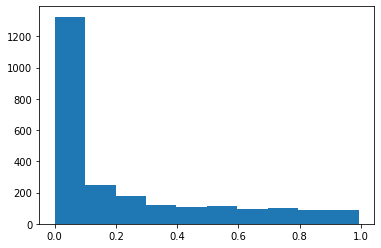

In [14]:
X = data_rms_filtered.drop('animal',axis=1).drop('batch',axis=1)
O,F,P=analysis.rank_sum_test(X[X['type']=='Hippocampal'].drop('type',1).values,
                       X[X['type']=='Cerebellar'].drop('type',1).values,features,10000)
plt.hist(P)

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


Text(0.5, 0, 'm/z')

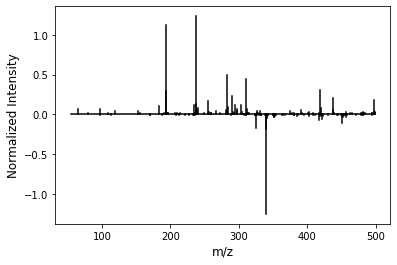

In [259]:
fig,axes=subplots(1,1,figsize=(8,6))
spec_diff = X[X['type']=='Hippocampal'].mean(0)-X[X['type']=='Cerebellar'].mean(0)
#spec_diff=spec_diff/spec_diff.max()
axes.stem(features,spec_diff,markerfmt=' ',basefmt='k',linefmt='k')
axes.set_ylabel('Normalized Intensity',fontsize=12)
axes.set_xlabel('m/z',fontsize=12)

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'm/z')

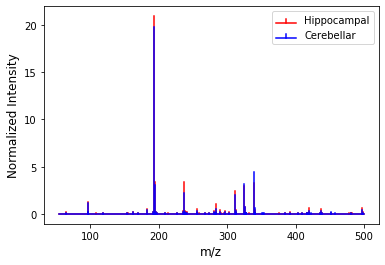

In [267]:
fig,axes=subplots(1,1,figsize=(6,4))
axes.stem(features,X[X['type']=='Hippocampal'].mean(0),markerfmt=' ',linefmt='r',basefmt='r',label='Hippocampal')
axes.stem(features,X[X['type']=='Cerebellar'].mean(0),markerfmt=' ',linefmt='b',basefmt='b',label='Cerebellar')
plt.legend()
axes.set_ylabel('Normalized Intensity',fontsize=12)
axes.set_xlabel('m/z',fontsize=12)

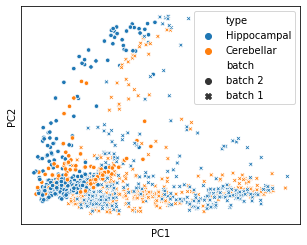

In [37]:
centered = X.drop('type',1)-X.drop('type',1).mean(0)
pca_result = analysis.PCanalysis(5,4,centered,False)

pca_df = pd.DataFrame(pca_result)
pca_df['type'] = data_rms_filtered['type'].values
pca_df['batch'] = data_rms_filtered['batch'].values

fig,axes = subplots(1,1,figsize=(5,4))
g=sns.scatterplot(x=0,y=1,hue='type',style='batch',data=pca_df,ax=axes,s=20)
g.legend(loc='upper right')
g.get_xaxis().set_ticks([])
g.get_yaxis().set_ticks([])

plt.xlabel('PC1')
plt.ylabel('PC2')
fig.savefig('plot/pca_HIP_CER.svg')

In [273]:
# match_mass_df = pd.read_excel('Metabolites - Adduct Calculator.xls','Negative Mode Values')
# match_mass_df

In [274]:
# data_rms_filtered = data_rms_filtered.drop(153.0195,axis=1)

# #adducts_list = ['M-3H','M-2H','M-H2O-H','M-H', 'M+Na-2H' ,'M+Cl' ,'M+K-2H']
# adducts_list = ['M-H']

# data_rms_matched,mass_data_all,mass_data_all2 = analysis.mass_match(data_rms_filtered,
#                                                            match_mass_df,
#                                                            adducts_list,5)
# print(mass_data_all.shape)
# mass_data_all2.head()

In [6]:
def split_data(data,test_size,random_state):
    
    data_cla = data.drop('type',axis=1).drop('animal',axis=1).drop('batch',axis=1).values
    data_bool = data_cla.astype(bool)
    label = data['type'].values
    label_batch = data['batch'].values
    masses = np.asarray(data.drop('type',axis=1).drop('animal',axis=1).drop('batch',axis=1).columns,float)
    features = np.asarray([format(float(x),'.4f') for x in masses],float)

    X_train_ = data_cla[data['batch']=='072419_HIP_CER']
    X_test_ = data_cla[data['batch']=='082719_HIP_CER']
    y_train_ = data[data['batch']=='072419_HIP_CER']['type'].values
    y_test_ = data[data['batch']=='082719_HIP_CER']['type'].values

    X_train, X_test, y_train, y_test = train_test_split(data_cla, label, test_size=test_size,random_state=random_state)
    X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(data_cla, label_batch, test_size=test_size,random_state=random_state)
    X_train_bool, X_test_bool, y_train_bool, y_test_bool = train_test_split(data_bool, label, test_size=test_size,random_state=random_state)
    X_train_batch_bool, X_test_batch_bool, y_train_batch_bool, y_test_batch_bool = train_test_split(data_bool, label_batch, test_size=test_size,random_state=random_state)

    data_dict = {'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test}
    data_dict_batch = {'X_train':X_train_batch,'X_test':X_test_batch,'y_train':y_train_batch,'y_test':y_test_batch}
    data_dict_cross_batch_forward = {'X_train':X_train_,'X_test':X_test_,'y_train':y_train_,'y_test':y_test_}
    data_dict_cross_batch_backward = {'X_train':X_test_,'X_test':X_train_,'y_train':y_test_,'y_test':y_train_}
    
    return data_dict, data_dict_batch, data_dict_cross_batch_forward,data_dict_cross_batch_backward,features

In [7]:
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

data_dict, data_dict_batch, data_dict_cross_batch_forward,data_dict_cross_batch_backward,features = split_data(data_rms_filtered,0.2,19)

# rf_model = RandomForestClassifier(n_estimators=2000)
X_train, X_test, y_train, y_test = data_dict['X_train'], data_dict['X_test'], data_dict['y_train'], data_dict['y_test']
xgb_mo = xgboost.XGBClassifier(n_estimators=500,subsample=1)
xgb_mo.fit(X_train,y_train)

y_pred_xgb_ = xgb_mo.predict(X_test)
prob_xgb_ = xgb_mo.predict_proba(X_test)
report_dict_xgb_ = classification_report(y_test, y_pred_xgb_, output_dict=True)

In [8]:
report_dict_xgb_

{'Cerebellar': {'precision': 0.9468085106382979,
  'recall': 0.956989247311828,
  'f1-score': 0.9518716577540107,
  'support': 93},
 'Hippocampal': {'precision': 0.9727891156462585,
  'recall': 0.9662162162162162,
  'f1-score': 0.9694915254237287,
  'support': 148},
 'accuracy': 0.9626556016597511,
 'macro avg': {'precision': 0.9597988131422781,
  'recall': 0.9616027317640221,
  'f1-score': 0.9606815915888698,
  'support': 241},
 'weighted avg': {'precision': 0.962763405000033,
  'recall': 0.9626556016597511,
  'f1-score': 0.9626921574018045,
  'support': 241}}

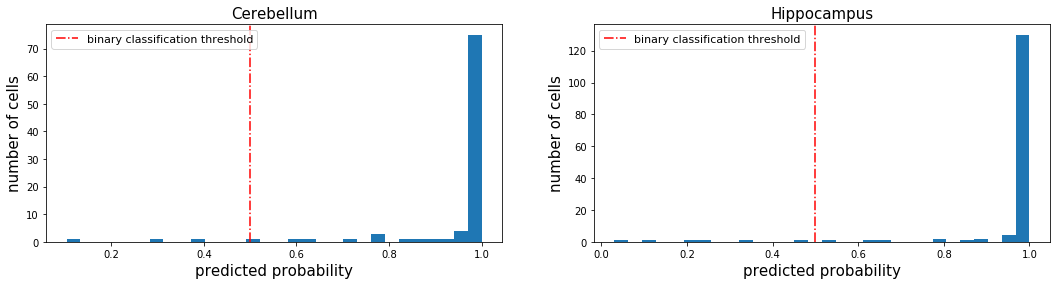

In [133]:
fig,axes = subplots(1,2,figsize=(18,4))
ax = axes.ravel()

ax[0].hist(prob_xgb_[np.where(y_test=='Cerebellar')[0],0],bins=30)
ax[0].set_title('Cerebellum',fontsize=15)
ax[1].hist(prob_xgb_[np.where(y_test=='Hippocampal')[0],1],bins=30)
ax[1].set_title('Hippocampus',fontsize=15)
ax[0].set_ylabel('number of cells',fontsize=15)
ax[1].set_ylabel('number of cells',fontsize=15)
ax[0].set_xlabel('predicted probability',fontsize=15)
ax[1].set_xlabel('predicted probability',fontsize=15)
ax[0].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[1].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[0].legend(fontsize=11,loc=2)
ax[1].legend(fontsize=11)

In [271]:
def plot_featureImp_glob(model,features,feature_num_shown):
    
    feature_imp = model.feature_importances_
#     feature_imp_index_ranked = np.argsort(feature_imp)[::-1]
#     features_ranked = features[feature_imp_index_ranked]
    feature_imp = feature_imp/feature_imp.max()
    fig,ax = subplots(figsize=(6,4))
    ax.stem(features,feature_imp,markerfmt=' ')
    
    features_selected = []
    for i in range(feature_num_shown):
        ax.scatter(float(features_ranked[i]),feature_imp[feature_imp_index_ranked][i],color='k',s=10)
        ax.annotate(format(float(features_ranked[i]),'.4f'), xy=(float(features_ranked[i]),feature_imp[feature_imp_index_ranked][i]),fontsize=8)
        features_selected.append(float(features_ranked[i]))
    ax.set_ylabel('relative importance')
    ax.set_xlabel('m/z')
    return fig, features_selected

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


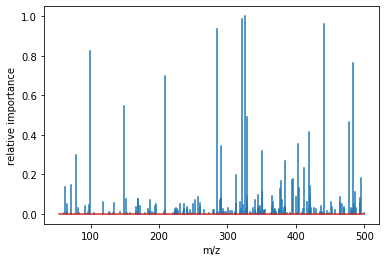

In [272]:
_,f_selected = plot_featureImp_glob(xgb_mo,features,0)

In [8]:
import shap
from adjustText import adjust_text

def feature_contrib(model,X,features,feature_num_shown,if_summary):
    
    shap_explainer = shap.TreeExplainer(model)
    shap_vals = shap_explainer.shap_values(X)
    
    fig1,axes = subplots(figsize=(12,4))
    
    g=axes.stem([float(x) for x in features],shap_vals.mean(axis=0),markerfmt=' ',linefmt='k')
    axes.get_yaxis().set_ticks([])
    shap_vals_index_ranked = np.argsort(shap_vals.mean(axis=0))[::-1]
    shap_vals_ranked = shap_vals.mean(axis=0)[shap_vals_index_ranked]
    #axes.spines['right'].set_visible(False)
    #axes.spines['top'].set_visible(False)
    texts = []
    axes.scatter(features[shap_vals_index_ranked[:feature_num_shown]],shap_vals_ranked[:feature_num_shown],color='b',s=35,marker='v',label='Hippocampal')
    axes.scatter(features[shap_vals_index_ranked[-feature_num_shown:]],shap_vals_ranked[-feature_num_shown:],color='orange',s=35,marker='s',label='Cerebellar')
    for i in range(feature_num_shown):
        texts.append(plt.text(float(features[shap_vals_index_ranked[i]]),shap_vals_ranked[i],float(features[shap_vals_index_ranked[i]]),fontsize=12))
        texts.append(plt.text(float(features[shap_vals_index_ranked[-i-1]]),shap_vals_ranked[-i-1],float(features[shap_vals_index_ranked[-i-1]]),fontsize=12))

#         axes.annotate(format(float(features[shap_vals_index_ranked[i]]),'.2f'), xy=(float(features[shap_vals_index_ranked[i]]),shap_vals_ranked[i]),fontsize=10)
#         axes.annotate(format(float(features[shap_vals_index_ranked[-i-1]]),'.2f'), xy=(float(features[shap_vals_index_ranked[-i-1]]),shap_vals_ranked[-i]),fontsize=10)
    axes.set_xlabel('m/z',fontsize=12)
    axes.set_ylabel('mean SHAP values',fontsize=12)
    axes.legend()
    adjust_text(texts)
    if if_summary:
        fig2,axes = subplots(figsize=(12,4))
        shap.summary_plot(shap_vals,X,max_display=15)
    return fig1,fig2,shap_vals


C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


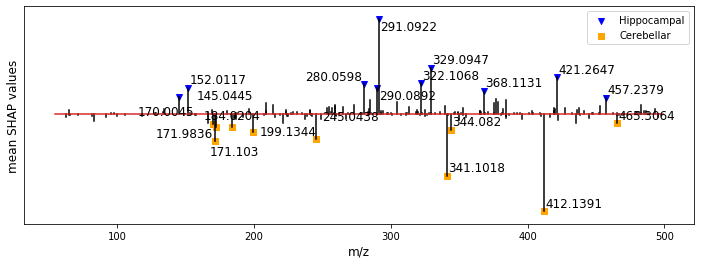

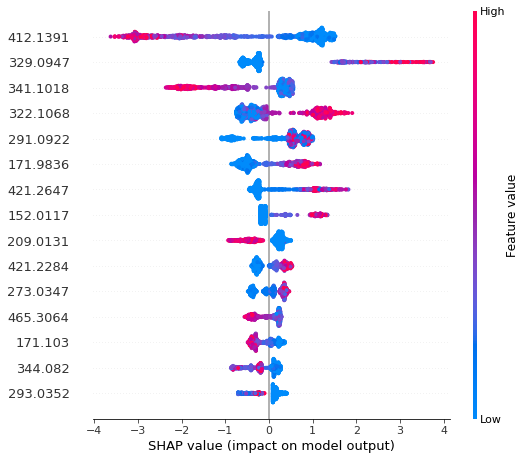

In [9]:
X_df = pd.DataFrame(data_rms_filtered.drop('type',axis=1).drop('animal',axis=1).drop('batch',axis=1))
X_df.columns = features
fig1,fig2,contrib_xgb_best = feature_contrib(xgb_mo,X_df,features,10,True)

In [113]:
fig1.savefig('plot/contribution_plot_HIP_CER_2.svg')
#fig2.savefig('plot/shap_plot_HIP_CER.svg')

In [15]:
shap_ranked_index = np.argsort(abs(contrib_xgb_best.mean(0)))[::-1]
gini_ranked_index = np.argsort(abs(xgb_mo.feature_importances_))[::-1]
rst_ranked_index = np.argsort(-P)[::-1]

shared_shap_gini = set(shap_ranked_index[:50]).intersection(set(gini_ranked_index[:50]))
shared_shap_rst = set(shap_ranked_index[:50]).intersection(set(rst_ranked_index[:50]))
shared_gini_rst = set(gini_ranked_index[:50]).intersection(set(rst_ranked_index[:50]))
shared_all = set(gini_ranked_index[:50]).intersection(set(rst_ranked_index[:50])).intersection(set(shap_ranked_index[:50]))

print(len(shared_shap_gini),len(shared_shap_rst),len(shared_gini_rst),len(shared_all))

16 15 12 9


In [16]:
common_feature = features[list(shared_all)]
common_feature = common_feature[np.argsort(common_feature)]
common_feature

array([290.0892, 291.0922, 322.1068, 377.2478, 378.2509, 396.1447,
       412.1391, 421.2647, 483.2545])

In [93]:
contrib_df = pd.DataFrame()
contrib_df['mass'] = features[shap_ranked_index]
contrib_df['mean SHAP'] = (np.around(contrib_xgb_best.mean(0),4))[shap_ranked_index]
contrib_df.loc[contrib_df['mean SHAP']>0,'contribute to which GOI']='Hippocampal'
contrib_df.loc[contrib_df['mean SHAP']<0,'contribute to which GOI']='Cerebellar'
contrib_df = contrib_df[contrib_df['mean SHAP']!=0]
contrib_df.to_csv('all_SHAP.csv',index=False)

In [94]:
contrib_df.head(10)

,mass,mean SHAP,contribute to which GOI
0,412.1391,-0.4359,Cerebellar
1,291.0922,0.4234,Hippocampal
2,341.1018,-0.2775,Cerebellar
3,329.0947,0.2065,Hippocampal
4,421.2647,0.1638,Hippocampal
5,322.1068,0.1363,Hippocampal
6,280.0598,0.1310,Hippocampal
7,171.1030,-0.1230,Cerebellar
8,152.0117,0.1170,Hippocampal
9,245.0438,-0.1145,Cerebellar


In [19]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

def shap_clustering(shap_vals,groups):
    
    shap_pca50 = PCA(n_components=12).fit_transform(shap_vals)
    #shap_embedded = TSNE(n_components=2, perplexity=25).fit_transform(shap_vals)
    
    cdict1 = {
        'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
                (1.0, 0.9607843137254902, 0.9607843137254902)),

        'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
                  (1.0, 0.15294117647058825, 0.15294117647058825)),

        'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
                 (1.0, 0.3411764705882353, 0.3411764705882353)),

        'alpha': ((0.0, 1, 1),
                  (0.5, 1, 1),
                  (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)
    
    shap_embedded_df = pd.DataFrame(shap_pca50)
    shap_embedded_df['type'] = groups

    f1,axes= subplots(1,1,figsize=(5,4))
    g = sns.scatterplot(x=0,y=1,hue='type',data=shap_embedded_df,ax=axes)
    g.legend(loc='upper right')
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticks([])
    axes.set_xlabel('PC1',fontsize=12)
    axes.set_ylabel('PC2',fontsize=12)
    
    f2,axes= subplots(1,1,figsize=(6,4))
    plt.scatter(shap_pca50[:,0],
           shap_pca50[:,1],
           c=shap_vals.sum(1).astype(np.float64),
           linewidth=0, alpha=0.9, cmap=red_blue_solid)
    cb = plt.colorbar(label="Log odds of being hippocampal or cerebellar", aspect=40, orientation="vertical")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position('bottom')
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticks([])
    axes.set_xlabel('PC1',fontsize=12)
    axes.set_ylabel('PC2',fontsize=12)
    plt.show()
    return f1,f2,shap_pca50

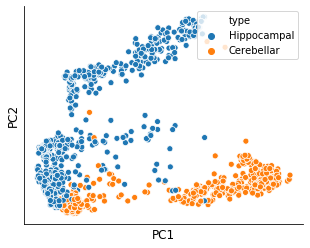

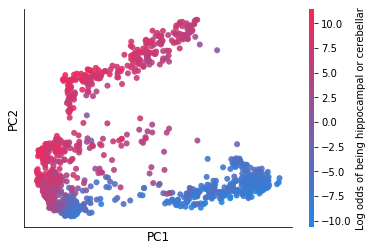

In [20]:
f1,f2,shap_pca = shap_clustering(contrib_xgb_best,data_rms_filtered['type'].values)

In [21]:
f1.savefig('plot/pca_SHAP_HIP_CER.svg')
f2.savefig('plot/pca_SHAP_prob_HIP_CER.svg')

In [24]:
def plot_shap_features(shap_vals,X,FOI):
    
    shap_pca = PCA(n_components=12).fit_transform(shap_vals)
    cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
    }  # #1E88E5 -> #ff0052
    red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)
    row_plot = int(np.ceil(len(FOI)/3))
    f,axes = subplots(3,row_plot,figsize=(row_plot*5,10))
    ax = axes.ravel()
    index = 0
    for feature in FOI:
        fig=ax[index].scatter(shap_pca[:,0],
                   shap_pca[:,1],
                   c=X[feature].values[:10000].astype(np.float64),
                   linewidth=0, alpha=0.75, cmap=red_blue_solid)
        cb=plt.colorbar(fig, aspect=40, orientation="vertical",ax=ax[index])
        cb.set_alpha(1)
        cb.set_label(label='normalized intensity',size=10)
        cb.draw_all()
        cb.outline.set_linewidth(0)
        cb.ax.tick_params('x', length=0)
        cb.ax.xaxis.set_label_position('top')
        ax[index].set_title(format(float(feature),'.4f')+' m/z',fontsize=12)
        ax[index].axis("off")
        index += 1
    return f

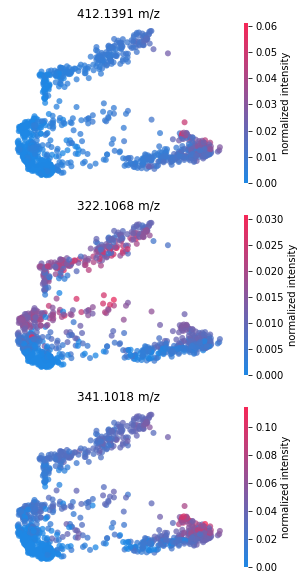

In [25]:
f=plot_shap_features(contrib_xgb_best,X_df,[412.1391,322.1068,341.1018])

In [26]:
f.savefig('plot/SHAP_features_HIP_CER.svg')

In [21]:
from sklearn.metrics import roc_curve, auc

a,b,c=roc_curve(y_test,prob[:,0])

fig,axes = subplots(figsize=(6,5))

axes.plot(a, b, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc(a,b))
axes.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes.set_xlim([-0.01, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('False Positive Rate',fontsize=14)
axes.set_ylabel('True Positive Rate',fontsize=14)
axes.legend(loc="lower right",fontsize=13)

ValueError: Data is not binary and pos_label is not specified

In [71]:
y_test[y_test=='H']=0
y_test[y_test=='C']=1
y_test = np.asarray(y_test,int)

In [10]:
from sklearn.metrics import roc_curve, auc

def feature_sampling(data,label,model,feature_num_sampled,sampling_num):
    
    label_ = label.copy()
    label_[label_=='Hippocampal'] = 1
    label_[label_=='Cerebellar'] = 0
    label_ = np.asarray(label_,int)
    acc = []
    recall = []
    f1 = []
    auc_ = []
    
    for i in range(sampling_num):
        data_sampled = data.sample(feature_num_sampled,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(data_sampled.values, label_, test_size=0.2,random_state=19)
        
        model.fit(X_train,y_train)

        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        acc.append(report_dict['accuracy'])
        recall.append(report_dict['macro avg']['recall'])
        f1.append(report_dict['macro avg']['f1-score'])
        
        a,b,c=roc_curve(y_test,y_pred_prob[:,1])
        print('auc: {}'.format(auc(a,b)))
        auc_.append(auc(a,b))
        
    return acc,recall,f1,auc_

In [11]:
data_rms_filtered_ = data_rms_filtered.drop('animal',1).drop('type',1).drop('batch',1)
label = data_rms_filtered['type'].values
acc,recall,f1,auc_ = feature_sampling(data_rms_filtered_,label,xgb_mo,24,300)

auc: 0.9017000871839581
auc: 0.9193548387096775
auc: 0.8484452194129614
auc: 0.7978785236849754
auc: 0.8858616681197327
auc: 0.9800203429235688
auc: 0.8579628015111885
auc: 0.884844521941296
auc: 0.8822290031967452
auc: 0.8843359488520779
auc: 0.7886515547805871
auc: 0.8281749491426911
auc: 0.9334495786108689
auc: 0.9341034582970068
auc: 0.8774702121476315
auc: 0.9385353095030514
auc: 0.9413687881429816
auc: 0.9727186864283639
auc: 0.8976315024702122
auc: 0.9435483870967742
auc: 0.9350479511769836
auc: 0.8570909619296715
auc: 0.8387823307178145
auc: 0.9124891020052311
auc: 0.9230601569311246
auc: 0.9561174077303108
auc: 0.8984306887532694
auc: 0.9657802964254576
auc: 0.9179744260389422
auc: 0.9434394071490846
auc: 0.9269834350479511
auc: 0.9614937518163325
auc: 0.8959604766056378
auc: 0.8384190642255158
auc: 0.9155042138913108
auc: 0.8704228421970358
auc: 0.8360215053763441
auc: 0.841833769253124
auc: 0.9134699215344377
auc: 0.8528770706190061
auc: 0.883137169427492
auc: 0.861450159837

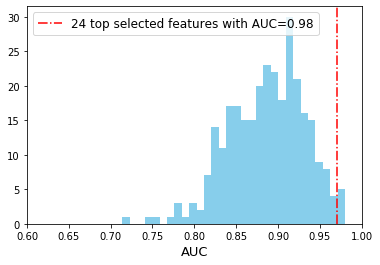

In [13]:
fig,axes = subplots(1,1)
axes.hist(auc_,bins=30, color = "skyblue")
axes.axvline(0.97,linestyle='-.',c='r',label='24 top selected features with AUC=0.98')
axes.set_xlim([0.6,1])
axes.set_xlabel('AUC',fontsize=13)
plt.legend(fontsize=12)
fig.savefig('plot/auc_dist_HIP_CER.svg')

In [14]:
def feature_select(data,label,model,ranked_index,steps):
    
    label_ = label.copy()
    label_[label_=='Hippocampal'] = 1
    label_[label_=='Cerebellar'] = 0
    label_ = np.asarray(label_,int)
    acc = []
    recall = []
    f1 = []
    auc_ = []
    
    for i in range(1,100):
        X_train, X_test, y_train, y_test = train_test_split(data.values, label_, test_size=0.2,random_state=19)
        model.fit(X_train[:,ranked_index[:i]],y_train)

        y_pred = model.predict(X_test[:,ranked_index[:i]])
        y_pred_prob = model.predict_proba(X_test[:,ranked_index[:i]])
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        acc.append(report_dict['accuracy'])
        recall.append(report_dict['macro avg']['recall'])
        f1.append(report_dict['macro avg']['f1-score'])
        
        a,b,c=roc_curve(y_test,y_pred_prob[:,1])
        print('auc: {}'.format(auc(a,b)))
        auc_.append(auc(a,b))
        
    return acc,recall,f1,auc_

In [15]:
shap_ranked_index = np.argsort(abs(contrib_xgb_best.mean(0)))[::-1]
acc1,recall1,f11,auc_1 = feature_select(data_rms_filtered_,label,xgb_mo,shap_ranked_index,100)

auc: 0.772994768962511
auc: 0.8771795989537925
auc: 0.8839000290613194
auc: 0.9349752978785237
auc: 0.9519035164196454
auc: 0.9590235396687011
auc: 0.9691950014530659
auc: 0.9725007265329846
auc: 0.974426038942168
auc: 0.9756611450159837
auc: 0.9800929962220284
auc: 0.9800203429235687
auc: 0.9800203429235687
auc: 0.981400755594304
auc: 0.9857599535018889
auc: 0.9863775065387969
auc: 0.9858689334495786
auc: 0.9865954664341761
auc: 0.9856873002034292
auc: 0.9865591397849462
auc: 0.9863411798895669
auc: 0.9850334205172915
auc: 0.9856146469049695
auc: 0.9790031967451323
auc: 0.9826358616681197
auc: 0.9803836094158674
auc: 0.984016274338855
auc: 0.9858326068003487
auc: 0.9835077012496367
auc: 0.9831444347573379
auc: 0.9848154606219122
auc: 0.9853240337111305
auc: 0.9877942458587621
auc: 0.9890293519325778
auc: 0.9925167102586457
auc: 0.9920081371694276
auc: 0.9921534437663471
auc: 0.9907730310956118
auc: 0.9904824179017728
auc: 0.9911362975879106
auc: 0.9906277244986923
auc: 0.9909183376925

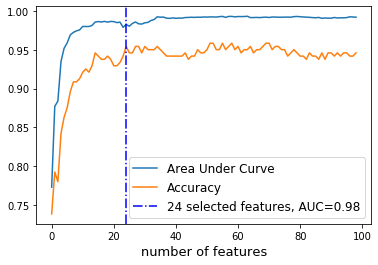

In [27]:
fig,axes = subplots(1,1)
axes.plot(auc_1,label='Area Under Curve')
axes.plot(acc1,label='Accuracy')
axes.axvline(24,linestyle='-.',c='b',label='24 selected features, AUC=0.98')
axes.set_xlabel('number of features',fontsize=13)
plt.legend(fontsize=12)
fig.savefig('plot/feat_select_HIP_CER.svg')